彭婷玉 201692392

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from keras.applications import Xception

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(299,299,3))

Using TensorFlow backend.


In [2]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

In [3]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(512,activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(133,activation='softmax'))

In [4]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 10, 10, 2048)      20861480  
_________________________________________________________________
flatten_1 (Flatten)          (None, 204800)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               104858112 
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 133)               68229     
Total params: 125,787,821
Trainable params: 125,733,293
Non-trainable params: 54,528
_________________________________________________________________


In [5]:
conv_base.trainable = False

In [6]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = './dogImages'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')

In [7]:
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers

train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=20,
        class_mode='categorical')

model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

Found 6680 images belonging to 133 classes.
Found 835 images belonging to 133 classes.


In [8]:
from keras.callbacks import ModelCheckpoint 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpointer = ModelCheckpoint(filepath='dogsImages.pretrained.augmentation.model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=334,
      epochs=10,
      validation_data=validation_generator,
      validation_steps=42, 
      callbacks=[checkpointer], 
      verbose=2)


Epoch 1/10
 - 933s - loss: 2.2487 - acc: 0.4972 - val_loss: 0.6290 - val_acc: 0.8120

Epoch 00001: val_loss improved from inf to 0.62902, saving model to dogsImages.pretrained.augmentation.model.weights.best.hdf5
Epoch 2/10
 - 872s - loss: 1.1914 - acc: 0.6897 - val_loss: 0.4899 - val_acc: 0.8371

Epoch 00002: val_loss improved from 0.62902 to 0.48994, saving model to dogsImages.pretrained.augmentation.model.weights.best.hdf5
Epoch 3/10
 - 897s - loss: 0.9926 - acc: 0.7275 - val_loss: 0.4291 - val_acc: 0.8527

Epoch 00003: val_loss improved from 0.48994 to 0.42912, saving model to dogsImages.pretrained.augmentation.model.weights.best.hdf5
Epoch 4/10
 - 899s - loss: 0.8728 - acc: 0.7638 - val_loss: 0.4079 - val_acc: 0.8587

Epoch 00004: val_loss improved from 0.42912 to 0.40794, saving model to dogsImages.pretrained.augmentation.model.weights.best.hdf5
Epoch 5/10
 - 882s - loss: 0.8210 - acc: 0.7768 - val_loss: 0.3954 - val_acc: 0.8719

Epoch 00005: val_loss improved from 0.40794 to 0.3

之前没加入dropout时，loss在第5轮开始收敛，所以此处设置的epochs=10。但是这里好像还不太够……于是先测试了一下，发现acc有0.86（和之前已经收敛的结果差不多），就打算在之后的finetuning里面再训练了。

In [9]:
model.load_weights('dogsImages.pretrained.augmentation.model.weights.best.hdf5')

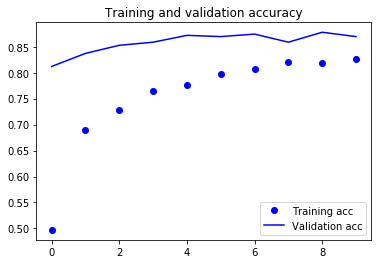

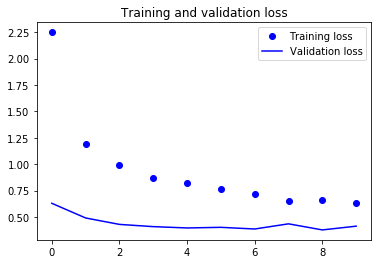

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299,299),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print("test_acc:",test_acc)

Found 836 images belonging to 133 classes.
test_acc: 0.8674698768849354


In [13]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block14_sepconv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [14]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=2e-5),
              metrics=['acc'])

In [15]:
from keras.callbacks import ModelCheckpoint 
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

checkpointer = ModelCheckpoint(filepath='dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5', 
                               verbose=1, 
                               save_best_only=True)
history = model.fit_generator(
      train_generator,
      steps_per_epoch=334,
      epochs=15,
      validation_data=validation_generator,
      validation_steps=42, 
      callbacks=[checkpointer], 
      verbose=2)

Epoch 1/15
 - 944s - loss: 0.6194 - acc: 0.8314 - val_loss: 0.4050 - val_acc: 0.8731

Epoch 00001: val_loss improved from inf to 0.40496, saving model to dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 2/15
 - 926s - loss: 0.5368 - acc: 0.8491 - val_loss: 0.4389 - val_acc: 0.8790

Epoch 00002: val_loss did not improve from 0.40496
Epoch 3/15
 - 927s - loss: 0.4357 - acc: 0.8720 - val_loss: 0.3948 - val_acc: 0.8743

Epoch 00003: val_loss improved from 0.40496 to 0.39485, saving model to dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 4/15
 - 939s - loss: 0.4048 - acc: 0.8754 - val_loss: 0.3932 - val_acc: 0.8862

Epoch 00004: val_loss improved from 0.39485 to 0.39317, saving model to dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5
Epoch 5/15
 - 934s - loss: 0.3719 - acc: 0.8877 - val_loss: 0.3628 - val_acc: 0.8814

Epoch 00005: val_loss improved from 0.39317 to 0.36276, saving model to dogsImages.pretrained.fin

In [16]:
model.load_weights('dogsImages.pretrained.finetuning.augmentation.model.weights.best.hdf5')

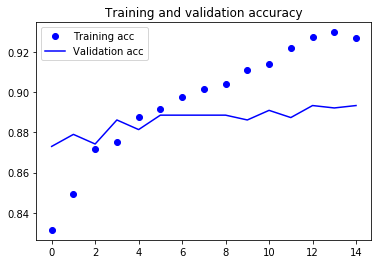

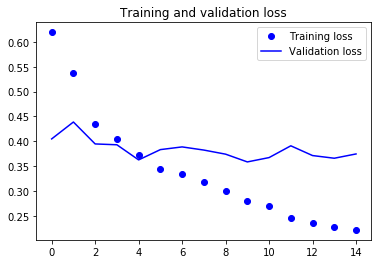

In [18]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

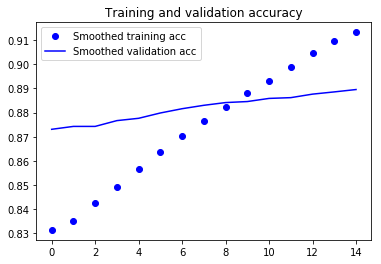

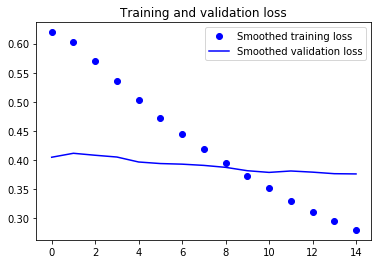

In [19]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor+point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs, smooth_curve(acc_f), 'bo', label='Smoothed training acc')
plt.plot(epochs, smooth_curve(val_acc_f), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, smooth_curve(loss_f), 'bo', label='Smoothed training loss')
plt.plot(epochs, smooth_curve(val_loss_f), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299,299),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print("test_acc:",test_acc)

Found 836 images belonging to 133 classes.
test_acc: 0.8935742935981138
